In [1]:
import numpy as np
import tensorflow as tf
tf.random.set_seed(450396580) 
from numpy.random import seed
seed(450396580)
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore') 
import os, random, cv2, h5py
from glob import glob
from sklearn.preprocessing import OneHotEncoder
from itertools import chain
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc, jaccard_score

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from keras.layers import Input, Dropout, Flatten, Dense, AveragePooling2D, Conv2D, GlobalAveragePooling2D
from keras.optimizers import Adam
import np_utils
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, CSVLogger

Using TensorFlow backend.


In [2]:
import segmentation_models as sm
from segmentation_models import Unet
#from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss

#from segmentation_models.losses import DiceLoss
from segmentation_models.metrics import iou_score

Segmentation Models: using `keras` framework.


In [3]:
# Using GPU 1
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [4]:
# Import data augmentation functions
from albumentations import (
    Compose,
    HorizontalFlip,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    OneOf,
    CLAHE,
    RandomBrightnessContrast,    
    RandomGamma    
)

In [5]:
# Weighting for reducing class imbalance
#weights = [0.4, 0.6, 0.5, 1]

In [6]:
IOU = sm.metrics.IOUScore() #iou is also known as the jaccard score
Fscore = sm.metrics.FScore() #also known as dice coeff

# DiceLoss with weighted class for balancing 
#loss = sm.losses.DiceLoss(class_weights=weights)

# Categorical Cross Entropy with weighted class for balancing 
#loss = sm.losses.CategoricalCELoss(class_weights = weights)

# Dice loss for unweighted classes
loss = sm.losses.DiceLoss()


# Learning rate
learning_rate=0.001

# This is a variable that will be used when saving model info, doesn't impact model training
lr='1e-3'


loss_name = 'DiceLoss'

metrics = [IOU, Fscore]

In [7]:
# Define optimiser - ref: Keras site
opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)

In [8]:
#Two classes are 0: BG, 1: SB - background and small bowel
class_dict = {0:'BG', 1:'SB'}

In [9]:
# File paths for Train, Test, Val for Images and Masks
ytrain_dir = 'Masks/Train'
xtrain_dir = 'Images/Train'

#ytest_dir = 'Masks/Test'
#xtest_dir = 'Images/Test'

yval_dir = 'Masks/Val'
xval_dir = 'Images/Val'

In [10]:
# Variables - try out different ones. Batch size 8 to 3 for trials
image_size = 256
batch_size = 3
epochs = 100
backbone = 'vgg16'

In [11]:
# Save_path creates model name summary - combined with variables later on e.g. weights, losses
save_path = f'Unet_b{batch_size}_e{epochs}_{backbone}_{lr}_binary_seg_1'

In [12]:
#save_path= 'JSRT_trained'

In [13]:
# Define augmentations to be made - ref: Albumentations site
aug = Compose([OneOf([
        ElasticTransform(p=1, alpha=200, sigma=200 * 0.05, alpha_affine=200 * 0.03),
        GridDistortion(p=1, border_mode=0, value=5)], p=0.8),
    CLAHE(p=0.8),
    HorizontalFlip(p=0.5),
    RandomBrightnessContrast(p=0.8),    
    RandomGamma(p=0.8)])

In [47]:
# Own datagenerator

# Classes = 1 (binary) - confirm this
# Batch and image size can be defined here, or will resort to default defined above 
# Batch size 8 to 3 for trial
def data_gen(img_folder, mask_folder, batch_size=3, image_size=256, classes=1):
    c=0
    # List of every image in the image folder
    n=os.listdir(img_folder)
    # Image and mask have same name therefore can shuffle 
    random.shuffle(n)
    
    while (True):
        # Create empty matrix for images with dimensions batch_size x image_sizeximage_size x 1
        img = np.zeros((batch_size, image_size, image_size, 1)).astype('float')
        # Create empty matrix for masks with dimensions batch_size x image_sizeximage_size x 1
        mask = np.zeros((batch_size, image_size, image_size, classes)).astype('float')
        
        # c initialised as 0 above, goes from 0 to 8 which is n 
        for i in range(c, c+batch_size):
            
            # Get train image and mask with matching names
            train_img = cv2.imread(os.path.join(img_folder,n[i]), cv2.IMREAD_GRAYSCALE)
            train_mask = cv2.imread(os.path.join(mask_folder,n[i]), cv2.IMREAD_GRAYSCALE)
            
            # Apply augmentation (# out if not using) - will do while testing on 1 img/mask
            #augmented = aug(image=train_img, mask=train_mask)
            #train_img = augmented['image']
            #train_mask = augmented['mask']
            
            # 0 indexing in python, so 0 to 255 not 1 to 256 
            train_img = cv2.resize(train_img, (image_size, image_size))/255.
            train_img = train_img.reshape([image_size, image_size,1])
            
            # img is 0 matrix created above. Replacing the 0's with the data
            img[i-c] = train_img #add to array img[0] img [1] etc
            
            # ravel and to_categorical possibly irrelevant for binary - confirm 
            train_mask = cv2.resize(train_mask, (image_size, image_size))
            #train_mask = train_mask.ravel()
            #train_mask = to_categorical(train_mask, num_classes=classes)
            train_mask = train_mask.reshape([image_size, image_size, classes])
            
            # mask is 0 matrix created above. Replacing the 0's with the data
            mask[i-c] = train_mask
        
        # Feed through the next batch of images
        c+=batch_size
        # If no more batches, reinitialises c again.Need so be theoretically infinite otherwise it doesn't work 
        if (c+batch_size>=len(os.listdir(img_folder))):
            c=0
            random.shuffle(n)
        
        # "return"
        yield img, mask

In [48]:
# Call when using test set

# Batch size = number ofimages in test folder (otherwise random errors with shuffling)
# Batch size = 1 also gets around this issue as it processes 1 image at a time
#def test_gen(img_folder, mask_folder, batch_size=51, image_size=256, classes=1):
 #   c=0
  #  n=os.listdir(img_folder)
   # n.sort() #always evaluate in the same order 
    #remove shuffling
    #while (True):
     #   img = np.zeros((batch_size, image_size, image_size, 1)).astype('float')
      #  mask = np.zeros((batch_size, image_size, image_size, classes)).astype('float')
        
       # for i in range(c, c+batch_size):
            
        #    train_img = cv2.imread(os.path.join(img_folder,n[i]), cv2.IMREAD_GRAYSCALE)/255.
         #   train_img = cv2.resize(train_img, (image_size, image_size))
          #  train_img = train_img.reshape([image_size, image_size,1])
            
           # img[i-c] = train_img #add to array img[0] img [1] etc
            
            #train_mask = cv2.imread(os.path.join(mask_folder,n[i]), cv2.IMREAD_GRAYSCALE)
            #train_mask = cv2.resize(train_mask, (image_size, image_size))
            ##train_mask = train_mask.ravel()
            ##train_mask = to_categorical(train_mask, num_classes=classes)
            #train_mask = train_mask.reshape([image_size, image_size, classes])
            
            #mask[i-c] = train_mask
            
        #c+=batch_size
        #if (c+batch_size>=len(os.listdir(img_folder))):
         #   c=0
        
        #yield img, mask

In [49]:
# Create variable to hold train data generator output 
train_gen = data_gen(xtrain_dir, ytrain_dir,image_size=image_size, batch_size=batch_size)

# Create variable to hold val data generator output 
val_gen = data_gen(xval_dir, yval_dir, image_size=image_size,batch_size=batch_size)

# Make validation and test batch size same as number of images in folder (see above for reasoning) 
#val_pred_generator =  test_gen(xval_dir, yval_dir, image_size=image_size, batch_size=51)
#test_generator = test_gen(xtest_dir, ytest_dir, image_size=image_size, batch_size=51)

In [50]:
# Counts number of training images in folder
no_training_images = len(os.listdir(xtrain_dir))

# Counts number of val images in folder
no_val_images = len(os.listdir(xval_dir))


# Save weights with "save_path" naming
weights_path = (f'Weights/{save_path}.h5')

# Kerascallback - save the minimum val_loss found
checkpoint = ModelCheckpoint(weights_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')

# Kerascallback - save epoch results with "save_path" naming  
csv_logger = CSVLogger(f'TrainingLog/{save_path}.out', append=True, separator=';')

# Kerascallback - stop training if val_loss doesn't improve after # (5) epochs
earlystopping = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)

# Kerascallbacks can be added above then included here
callbacks_list = [checkpoint, csv_logger, earlystopping]


In [51]:
# This section will change for TL (esp encoder weights)
# For binary; classes changed to 1 and softmax changed to sigmoid
model = Unet(backbone_name='vgg16', encoder_weights=None, classes=1, activation = 'sigmoid', encoder_freeze = False, input_shape=(image_size, image_size, 1))

In [52]:
# Can call on previously created models, look at the model summary
#from keras.models import load_model
#model = load_model('trained_model.hdf5')

In [53]:
#model.summary()

In [54]:
#model.load_weights('Weights/Unet_b8_e200_vgg16_1e-4_aug_fromscratch_weights_uncropped.h5')

In [55]:
# Putting the model all together with optimiser, loss function and metrics (iou and F1)
model.compile(opt, loss=loss, metrics=metrics)

In [56]:
#model.load_weights(f'Weights/Unet_s{image_size}_b{batch_size}_e{epochs}_{backbone}_{loss_name}.best.hdf5')

In [57]:
# TRAINS MODEL ON DATA GENERATED BATCH-BY-BATCH

# Augmentation doesn't physically increase # of images in folder, so if you augment, need to update *#  for steps per epoch to match the correct number of images being trained on
results = model.fit_generator(train_gen, epochs=epochs, 
                          steps_per_epoch = (no_training_images*1//batch_size),
                          validation_data=val_gen,
                          validation_steps=(no_val_images//batch_size), 
                             verbose=1, 
                             callbacks = callbacks_list)

Epoch 1/100


error: OpenCV(4.2.0) /io/opencv/modules/imgproc/src/resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [29]:
#model.save_weights(f'Weights/{save_path}_lr00001.h5')

In [30]:
# Training is now finished
# Save results in training log with "save_path" name, used for graphing
path = f'TrainingLog/{save_path}.out'
history = pd.read_csv(path, sep=';')

In [31]:
def plot_history(history, save=False, name=None):
    fig, (ax1, ax2) = plt.subplots(ncols=2)
    ax1.plot(history['iou_score'])
    ax1.plot(history['val_iou_score'])
    ax1.title.set_text('Model Accuracy')
    ax1.set_ylabel('Jaccard Score')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='lower right')
    
    # Plot training & validation loss values
    ax2.plot(history['loss'])
    ax2.plot(history['val_loss'])
    ax2.title.set_text('Model loss')
    ax2.set_ylabel('Jaccard Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper right')
    fig.tight_layout()
    fig.show()
    if save==False:
        return
    else:
        fig.savefig(f'Figures/{name}.png')
        
    return

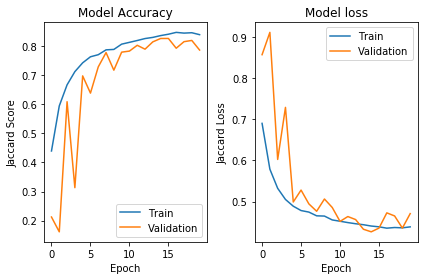

In [32]:
plot_history(history, save = True, name = save_path)

In [21]:
# might change for binary - reserach and adapt. 4 is the classes, so would likely change that
def get_class_jaccard(image_folder, mask_folder, generator):
    image_names = os.listdir(image_folder)
    image_names.sort()
    
    predictions = model.predict_generator(generator, steps=1)
    
    ytrue = np.zeros((51, image_size, image_size, 4)).astype('float')

    for i in range(51):
        target = cv2.imread(os.path.join(mask_folder, image_names[i]), cv2.IMREAD_GRAYSCALE)
        target = cv2.resize(target, (image_size, image_size))
        target = target.ravel()
        target = to_categorical(target, num_classes=4)
        target = target.reshape([image_size, image_size, 4])
        
        ytrue[i] = target
    
    ypred = np.argmax(predictions, axis=-1)
    ytrue = np.argmax(ytrue, axis=-1)
    
    scores = jaccard_score(ytrue.ravel(), ypred.ravel(), average=None)
    
    #change this probably too 
    return print(f'BG: {scores[0]}, Heart: {scores[1]}, Lungs: {scores[2]}, Clavicles: {scores[3]}')

In [30]:
get_class_jaccard(xtest_dir, ytest_dir, test_generator)

BG: 0.7051774567248774, Heart: 0.0, Lungs: 0.0, Clavicles: 0.0


In [23]:
get_class_jaccard(xval_dir, yval_dir, val_pred_generator)

BG: 0.6889771106196385, Heart: 0.0, Lungs: 0.0, Clavicles: 0.0


In [35]:
#plotting segmentation over image
image_names = os.listdir(xval_dir)
image_names.sort()
#generating predictions for this folder. Keras thing - look at documentation 
predictions = model.predict_generator(val_pred_generator, steps=1)
ypred = np.argmax(predictions, axis=-1)

In [31]:
# same as above but for test. comment out depending on if you're using val or test (same variable name)
image_names = os.listdir(xtest_dir)
image_names.sort()
predictions = model.predict_generator(test_generator, steps=1)
ypred = np.argmax(predictions, axis=-1)

In [37]:
#plotting - Keras
def plot_pred(index, predictions = ypred, save=False):
    img = cv2.imread(os.path.join('Images/Segmenting/Val/',image_names[index]), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (image_size, image_size))   
    
    target = cv2.imread(os.path.join(yval_dir, image_names[index]), cv2.IMREAD_GRAYSCALE)
    target = cv2.resize(target, (image_size, image_size))
    
    scores = jaccard_score(target.ravel(), ypred[index].ravel(), average=None)
    
    fig = plt.figure(frameon=False)
    im1 = plt.imshow(img, cmap='gray')
    im2 = plt.imshow(ypred[index], cmap = 'plasma', alpha=0.4)
    plt.axis('off')
    plt.annotate(f'IoU Heart: {round(scores[1]*100,2)}, Lungs: {round(scores[2]*100,2)},\n Clavicles: {round(scores[3]*100,2)}',(image_size*0.1, image_size*0.95), color='white')
    
    if save == True:
        plt.savefig(f'Figures/{save_path}_{image_names[index]}.png')
    
    plt.show()
    

In [25]:
def plot_testpred(index, predictions = ypred, save=False):
    img = cv2.imread(os.path.join('Images/Segmenting/Test/',image_names[index]), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (image_size, image_size))   
    
    target = cv2.imread(os.path.join(ytest_dir, image_names[index]), cv2.IMREAD_GRAYSCALE)
    target = cv2.resize(target, (image_size, image_size))
    
    scores = jaccard_score(target.ravel(), ypred[index].ravel(), average=None)
    
    fig = plt.figure(frameon=False)
    im1 = plt.imshow(img, cmap='gray')
    im2 = plt.imshow(ypred[index], cmap = 'plasma', alpha=0.4)
    plt.axis('off')
    plt.annotate(f'IoU Heart: {round(scores[1]*100,2)}, Lungs: {round(scores[2]*100,2)},\n Clavicles: {round(scores[3]*100,2)}',(image_size*0.1, image_size*0.95), color='white')
    
    if save == True:
        plt.savefig(f'Figures/TestFigs/{save_path}_{image_names[index]}.png')
    
    plt.show()

In [34]:
predictions.shape

(51, 256, 256, 1)

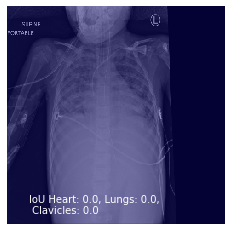

In [32]:
plot_testpred(50, ypred, save=False)

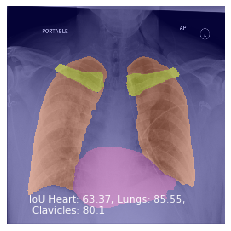

In [40]:
plot_pred(49, ypred, save=True)

In [41]:
#img = cv2.imread(os.path.join('Images/Segmenting/Val/',image_names[2]), cv2.IMREAD_GRAYSCALE)
#img = cv2.resize(img, (image_size, image_size))
#
#fig = plt.figure(frameon=False)
#im1 = plt.imshow(img, cmap='gray')
#im2 = plt.imshow(predictions[2,:,:,3], cmap = 'plasma', alpha=0.4)
#plt.axis('off')
##plt.annotate(f'IoU Heart: {round(scores[1]*100,2)}, Lungs: {round(scores[2]*100,2)},\n Clavicles: {round(scores[3]*100,2)}',(image_size*0.1, image_size*0.95), color='white')
#plt.savefig(f'Figures/Test/epoch14clavicles.png')
#plt.show()

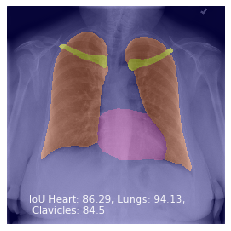

In [42]:
plot_pred(1, ypred, save=True)

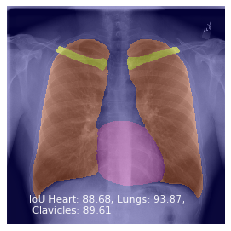

In [43]:
plot_pred(18, ypred, save=True)

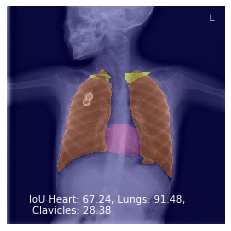

In [44]:
plot_pred(23, ypred, save=True)